# Setup



In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Install necessary libraries & download models here

In [ ]:
#!pip install spacy
#!python -m spacy download en_core_web_md

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

plt.style.use('ggplot')

## Read in data and explore

In [14]:
df = pd.read_csv('/content/drive/MyDrive/amazon_review_dataset/Reviews.csv')
print(df.shape)

(568454, 10)


In [15]:
df.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [17]:
example_1 = df['Text'][1]
print(example_1 ) # negative review
print("\n")
example_2 = df['Text'][2]
print(example_2) # highly positive review

Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".


This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.


# distribution of the stars of the reviews

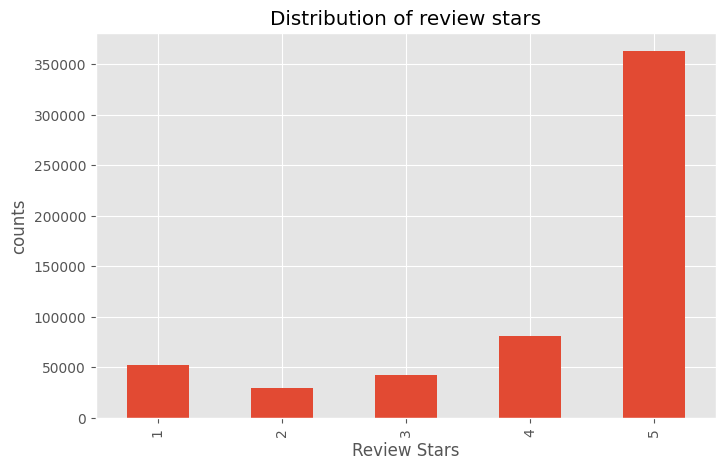

In [18]:
ax = df['Score'].value_counts().sort_index().plot(kind='bar',
                                                  title='Distribution of review stars',
                                                  figsize=(8, 5),
                                                  xlabel = "Review Stars",
                                                  ylabel = 'counts')

plt.show()

We see the dataset is unbalanced, accroding to the stars, we're expected to see more positive reviews with higher number of stars and vice versa.

# **NOTE: for the purpose of this project, we use the stars are labels to verify the accuracy of our models.**

# Play with different models

## a. Vader (bag of n-grams)

In [19]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

SIA = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [20]:
# an example
SIA.polarity_scores('i love data')

{'neg': 0.0, 'neu': 0.192, 'pos': 0.808, 'compound': 0.6369}

In [21]:
# Run the polarity score on the entire dataset
result_vader = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    index = row['Id']
    result_vader[index] = SIA.polarity_scores(text)

  0%|          | 0/568454 [00:00<?, ?it/s]

In [22]:
vaders = pd.DataFrame(result_vader).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df[["Id","UserId", "Text", "Score"]], how = "left", left_on = "Id", right_on = "Id")

In [23]:
vaders.head()

,Id,neg,neu,pos,compound,UserId,Text,Score
0,1,0.000,0.695,0.305,0.9441,A3SGXH7AUHU8GW,I have bought several of the Vitality canned d...,5
1,2,0.138,0.862,0.000,-0.5664,A1D87F6ZCVE5NK,Product arrived labeled as Jumbo Salted Peanut...,1
2,3,0.091,0.754,0.155,0.8265,ABXLMWJIXXAIN,This is a confection that has been around a fe...,4
3,4,0.000,1.000,0.000,0.0000,A395BORC6FGVXV,If you are looking for the secret ingredient i...,2
4,5,0.000,0.552,0.448,0.9468,A1UQRSCLF8GW1T,Great taffy at a great price. There was a wid...,5


## plotting the result

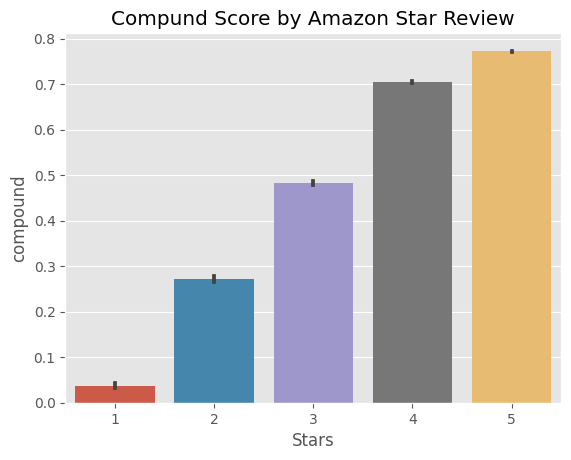

In [24]:
ax = sns.barplot(data=vaders, x='Score', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
ax.set(xlabel='Stars')
plt.show()

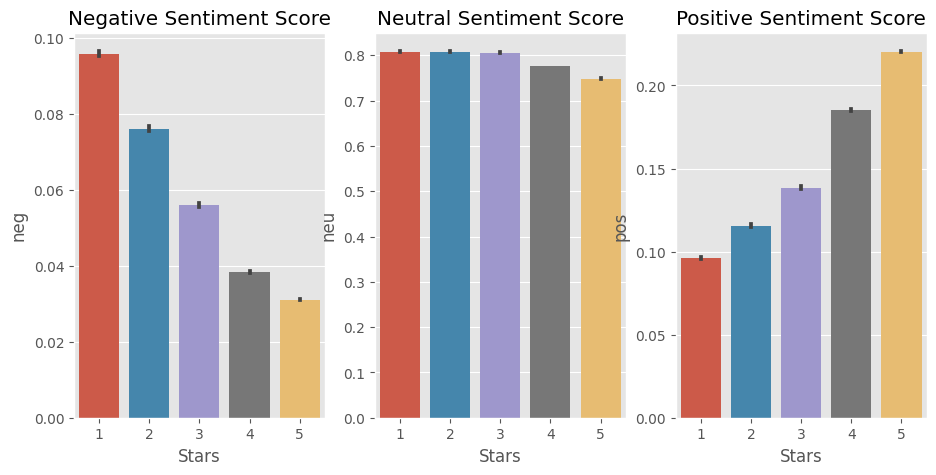

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(11, 5))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[2])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[0])
axs[2].set(title = 'Positive Sentiment Score', xlabel = 'Stars')
axs[1].set(title = 'Neutral Sentiment Score', xlabel = 'Stars')
axs[0].set(title = 'Negative Sentiment Score', xlabel = 'Stars')
plt.show()

We see these plots align with our hypothesis that if lower the number of stars the more negative the review is and vice versa!

# Drawback

In [26]:
SIA.polarity_scores('i don\'t think the movie is good') # negative

{'neg': 0.0, 'neu': 0.633, 'pos': 0.367, 'compound': 0.4404}

In [27]:
SIA.polarity_scores('i can\'t believe how good the book is') # positive

{'neg': 0.286, 'neu': 0.714, 'pos': 0.0, 'compound': -0.3412}

In the above example we see that the result is not accurate at all. This is because the Vader model use bag of n-grams approach, i.e. it take tokens individually without considering the sequence/order, which is important in human languages, for sentiment analysis

# b. BERT





BERT is a **bidirectional** transformer pretrained using a combination of masked language modeling objective and next sentence prediction on a large corpus comprising the Toronto Book Corpus and Wikipedia.

Resources:

*  [The paper](https://arxiv.org/abs/1810.04805)
*  [Google's blog on BERT](https://blog.research.google/2018/11/open-sourcing-bert-state-of-art-pre.html)







In [ ]:
#!pip install transformers

In [29]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [30]:
# we use bert-base-multilingual-uncased-sentiment model here
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [31]:
# example
encoded_text_bert = tokenizer('i love my cat, he is so cute', return_tensors='pt')
output_bert = model(**encoded_text_bert)
# return a integer between 1-5 with increaseing positivity
scores = int(torch.argmax(output_bert.logits))+1
print(scores) # ofc a 5, we love cats

5


In [32]:
def sentiment_bert(text):
  encoded_text_bert = tokenizer(text, return_tensors='pt')
  output_bert = model(**encoded_text_bert)
  # return a integer between 1-5 with increaseing positivity
  score_bert = int(torch.argmax(output_bert.logits))+1
  return score_bert

In [33]:
# we perform the task on a subset of the dataset with 1000 entries
df_sma = df.head(1000)

result_bert = {}
for i, row in tqdm(df_sma.iterrows(), total=len(df_sma)):
    try:
        text = row['Text']
        myid = row['Id']
        bert_score = sentiment_bert(text)
        result_bert[myid] = bert_score
    # the max length of tokens the model can take is 512, reviews longer than that
    #   will break the program so we skip them
    except RuntimeError:
        print(f'Broke for id {myid}')



  0%|          | 0/1000 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (611 > 512). Running this sequence through the model will result in indexing errors


Broke for id 83
Broke for id 187
Broke for id 371
Broke for id 529
Broke for id 540
Broke for id 603
Broke for id 746
Broke for id 863
Broke for id 866


In [34]:
bert_final_df = pd.DataFrame([result_bert]).T
bert_final_df = bert_final_df.reset_index().rename(columns={'index': 'Id'})
bert_final_df = bert_final_df.merge(df_sma[["Id","UserId", "Text", "Score"]], how = "left", left_on = "Id", right_on = "Id")
bert_final_df = bert_final_df.rename(columns = {0 : 'sentiment score'})

bert_final_df.head(10)

,Id,sentiment score,UserId,Text,Score
0,1,5,A3SGXH7AUHU8GW,I have bought several of the Vitality canned d...,5
1,2,1,A1D87F6ZCVE5NK,Product arrived labeled as Jumbo Salted Peanut...,1
2,3,5,ABXLMWJIXXAIN,This is a confection that has been around a fe...,4
3,4,5,A395BORC6FGVXV,If you are looking for the secret ingredient i...,2
4,5,5,A1UQRSCLF8GW1T,Great taffy at a great price. There was a wid...,5
5,6,4,ADT0SRK1MGOEU,I got a wild hair for taffy and ordered this f...,4
6,7,5,A1SP2KVKFXXRU1,This saltwater taffy had great flavors and was...,5
7,8,5,A3JRGQVEQN31IQ,This taffy is so good. It is very soft and ch...,5
8,9,5,A1MZYO9TZK0BBI,Right now I'm mostly just sprouting this so my...,5
9,10,4,A21BT40VZCCYT4,This is a very healthy dog food. Good for thei...,5


In [35]:
## compare the sentiment score from BERT with the stars the user rated
##    tolerance +- 1
bert_final_df['aligned'] = bert_final_df.apply(lambda x: 1 if x['sentiment score'] == x['Score']\
                                               or x['sentiment score'] +1 == x['Score']\
                                               or x['sentiment score'] -1 == x['Score']\
                                               else 0, axis=1)
bert_final_df.head()

,Id,sentiment score,UserId,Text,Score,aligned
0,1,5,A3SGXH7AUHU8GW,I have bought several of the Vitality canned d...,5,1
1,2,1,A1D87F6ZCVE5NK,Product arrived labeled as Jumbo Salted Peanut...,1,1
2,3,5,ABXLMWJIXXAIN,This is a confection that has been around a fe...,4,1
3,4,5,A395BORC6FGVXV,If you are looking for the secret ingredient i...,2,0
4,5,5,A1UQRSCLF8GW1T,Great taffy at a great price. There was a wid...,5,1


In [36]:
# calculate the accuracy
correct = bert_final_df['aligned'].sum()
correct_rate = correct / (1000-9)
print(correct_rate)

0.9243188698284561


## c. RoBERTa

RoBERTa builds on BERT and modifies key hyperparameters, removing the next-sentence pretraining objective and training with much larger mini-batches and learning rates.

Resources:

*   [The paper](https://arxiv.org/abs/1907.11692)





In [37]:
from transformers import RobertaForSequenceClassification

tokenizer_robeta = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model_roberta = RobertaForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")


In [38]:
# example
encoded_text_ro = tokenizer_robeta('I love my cat, he is so cute', return_tensors='pt')
output_ro = model_roberta(**encoded_text_ro)
scores_ro = output_ro.logits[0].detach().numpy()
scores_ro = softmax(scores_ro)
scores_ro_dict = {
      'roberta_neg' : scores_ro[0],
      'roberta_neu' : scores_ro[1],
      'roberta_pos' : scores_ro[2]
}
print(scores_ro_dict)

{'roberta_neg': 0.00279942, 'roberta_neu': 0.0062728, 'roberta_pos': 0.99092776}


In [39]:
# function that return the sentiment scores
def sentiment_roberta(text):
  encoded_text_ro = tokenizer_robeta(text, return_tensors='pt')
  output_ro = model_roberta(**encoded_text_ro)
  scores_ro = output_ro.logits[0].detach().numpy()
  scores_ro = softmax(scores_ro)
  scores_ro_dict = {
      'roberta_neg' : scores_ro[0],
      'roberta_neu' : scores_ro[1],
      'roberta_pos' : scores_ro[2]
  }
  return scores_ro_dict

In [40]:
# like what we did for BERT, we're gonna perform the task on the 1000 entries subset
result_roberta = {}
for i, row in tqdm(df_sma.iterrows(), total=len(df_sma)):
    try:
        text = row['Text']
        myid = row['Id']
        roberta_scores = sentiment_roberta(text)
        result_roberta[myid] = roberta_scores
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187
Broke for id 529
Broke for id 540
Broke for id 746
Broke for id 863


In [41]:
roberta_results_df = pd.DataFrame(result_roberta).T
roberta_results_df = roberta_results_df.reset_index().rename(columns={'index': 'Id'})
roberta_results_df = roberta_results_df.merge(df_sma[["Id","UserId", "Text", "Score"]], how = "left", left_on = "Id", right_on = "Id")

roberta_results_df.head()

,Id,roberta_neg,roberta_neu,roberta_pos,UserId,Text,Score
0,1,0.009624,0.049980,0.940395,A3SGXH7AUHU8GW,I have bought several of the Vitality canned d...,5
1,2,0.508986,0.452414,0.038600,A1D87F6ZCVE5NK,Product arrived labeled as Jumbo Salted Peanut...,1
2,3,0.003229,0.098067,0.898704,ABXLMWJIXXAIN,This is a confection that has been around a fe...,4
3,4,0.002295,0.090219,0.907486,A395BORC6FGVXV,If you are looking for the secret ingredient i...,2
4,5,0.001635,0.010302,0.988063,A1UQRSCLF8GW1T,Great taffy at a great price. There was a wid...,5


### plot the data

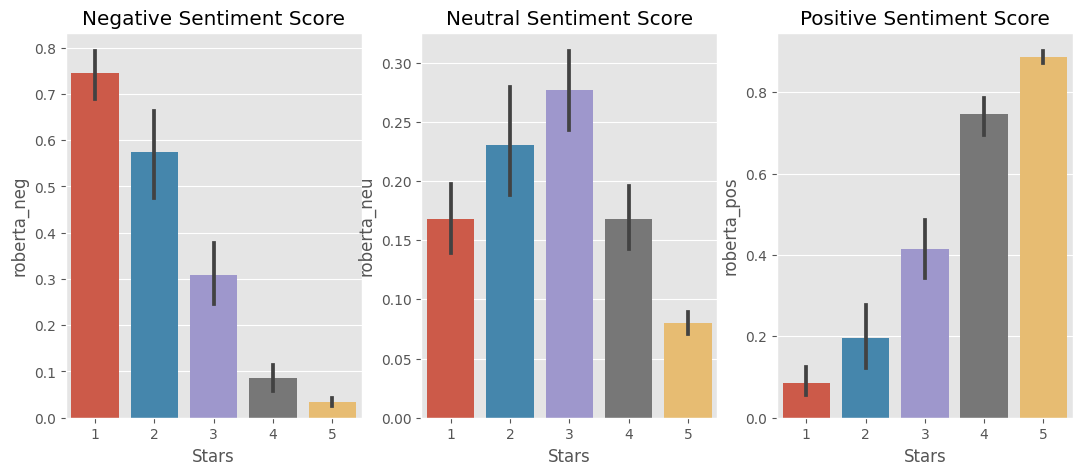

In [42]:
fig, axs = plt.subplots(1, 3, figsize=(13, 5))
sns.barplot(data=roberta_results_df, x='Score', y='roberta_pos', ax=axs[2])
sns.barplot(data=roberta_results_df, x='Score', y='roberta_neu', ax=axs[1])
sns.barplot(data=roberta_results_df, x='Score', y='roberta_neg', ax=axs[0])
axs[2].set(title = 'Positive Sentiment Score', xlabel = 'Stars')
axs[1].set(title = 'Neutral Sentiment Score', xlabel = 'Stars')
axs[0].set(title = 'Negative Sentiment Score', xlabel = 'Stars')
plt.show()

Like Vader, the positive and negative sentiment scores behave like what we expected (the more the stars, the more positive the reviews). However, unlike how the neutral sentiments score are evenly distributed in Vader, Roberta has a normal distribution, which make sense because 3 out of 5 means a netural rating and the more extreme the stars, the less netural the rating.